# VAE model building

## Import module

In [1]:
from keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Conv2DTranspose
from keras.layers import Activation,BatchNormalization,Reshape
from keras.models import Model
from keras.datasets import fashion_mnist,mnist
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import Adam
from keras import initializers
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

Using TensorFlow backend.


In [2]:
def sampling(arg):
    arg = [z_mean,z_log_var]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),mean=0.0, stddev=1.0) # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
fmnist_label = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}
y_train = list(map(lambda x:fmnist_label[x], y_train))
y_test = list(map(lambda x:fmnist_label[x], y_test))

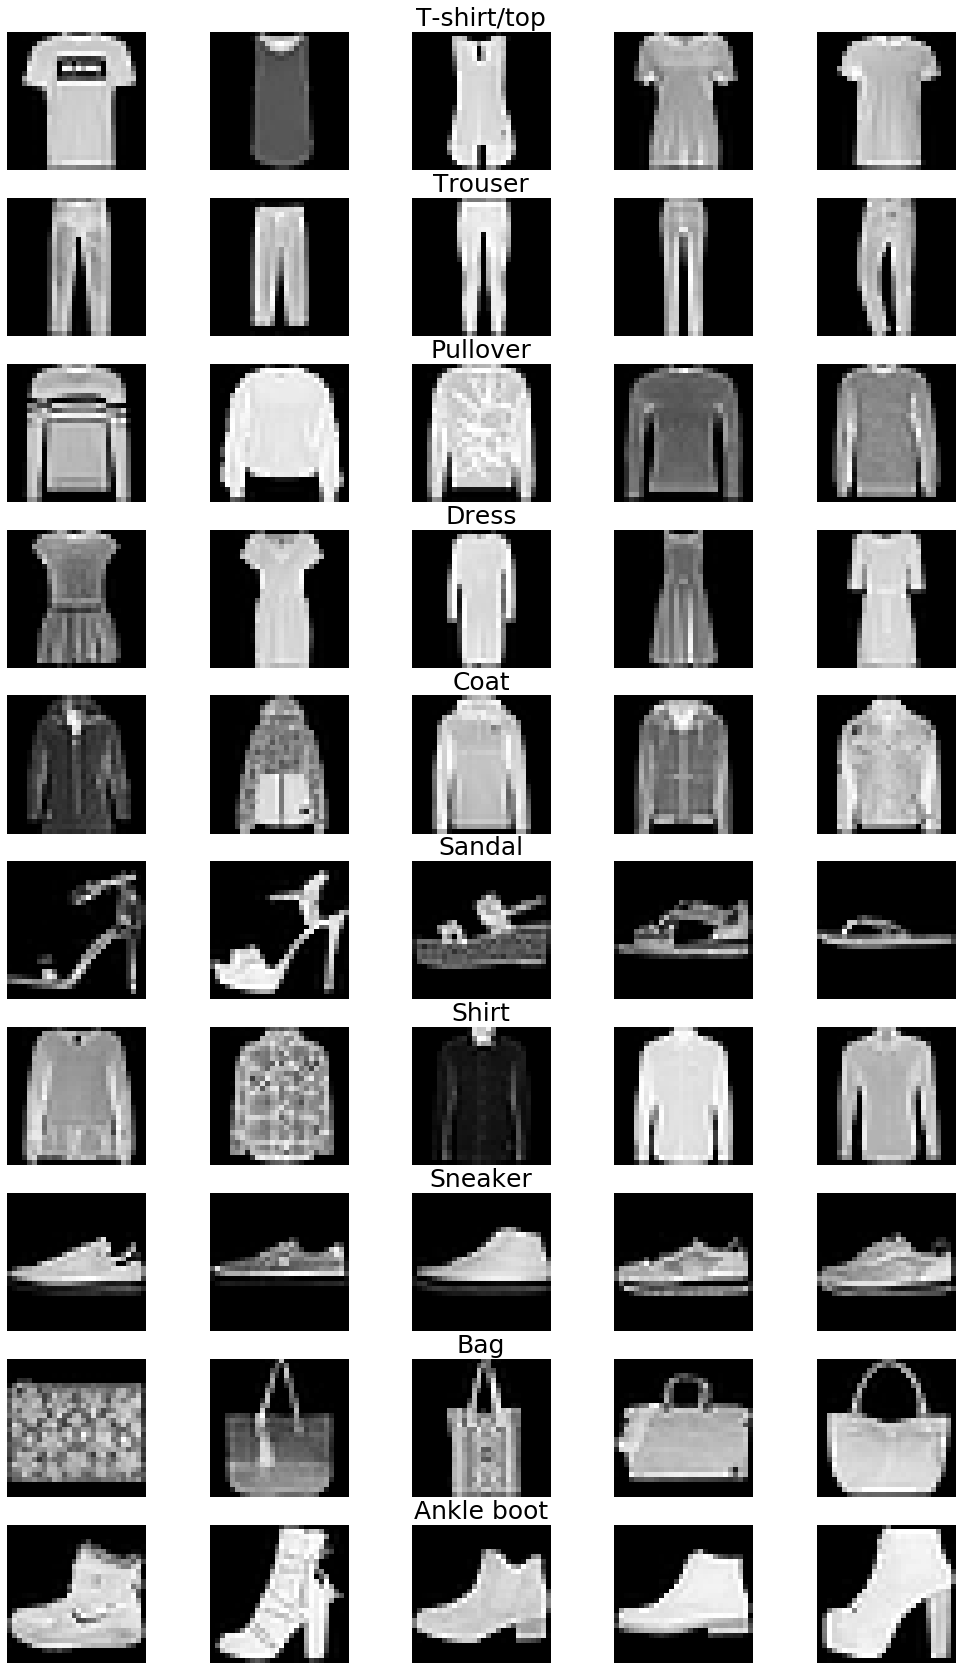

In [4]:
n_samples = 5
n_cls = len(np.unique(y_train))
fig, rows = plt.subplots(n_cls,n_samples,figsize=(4*n_samples,3*n_cls))

for row,cls in zip(rows,range(n_cls)):
    row[int(np.floor(n_samples/2))].set_title(fmnist_label[cls],fontsize=25)
    for col_ax,img_idx in zip(row,[i for i,v in enumerate(y_train) if v==fmnist_label[cls]][:n_samples]):
        img = X_train[img_idx]
        col_ax.imshow(img,cmap='gray')
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)

In [5]:
X_train = np.expand_dims(X_train,-1)
X_test =  np.expand_dims(X_test,-1)
X_train = X_train.astype('float32')/127.5-1 # for tanh
X_test = X_test.astype('float32')/127.5-1
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [6]:
channel = 1
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
input_shape = (img_rows,img_cols,channel)
batch_size = 128
latent_dim = 30
epochs = 100
learning_rate = 0.001
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=1,factor=0.5,min_lr=0.00001)

## Encoder

In [7]:
w_init = initializers.random_normal(stddev=0.02)
gamma_init = initializers.random_normal(mean=1.0,stddev=0.02)

inputs = Input(shape=input_shape)

x = Conv2D(16,3,strides=1,padding='same',kernel_initializer=w_init)(inputs)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(32,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(64,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
before_flatten_shape = K.int_shape(x)

x_z = Flatten()(x)
z_mean = Dense(latent_dim,kernel_initializer=w_init,name='z_mean')(x_z)
z_mean = BatchNormalization(gamma_initializer=gamma_init)(z_mean)

x_var = Flatten()(x)
z_log_var = Dense(latent_dim,kernel_initializer=w_init,name='z_log_var')(x_var)
z_log_var = BatchNormalization(gamma_initializer=gamma_init)(z_log_var)

# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean,z_log_var,z])
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Decoder

In [8]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(before_flatten_shape[1]*before_flatten_shape[2]*before_flatten_shape[3],activation='relu',kernel_initializer=w_init)(latent_inputs)
x = Reshape((before_flatten_shape[1],before_flatten_shape[2],before_flatten_shape[3]))(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)

x = Conv2DTranspose(64,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(16,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

outputs = Conv2DTranspose(channel,3,activation='tanh',padding='same',kernel_initializer=w_init)(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              97216     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 64)        0         
__________

## VAE

In [9]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [10]:
beta = 1 # 1 --> regular VAE
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols

kl_loss = -0.5*beta*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
vae_loss = K.mean(reconstruction_loss+kl_loss)

In [11]:
os.makedirs('best_weight_vae_v1',exist_ok=True)
best_model_weight_path = os.path.join('best_weight_vae_v1','vae_v1'+'-best-wiehgts'+'-{epoch:03d}-{loss:.3f}-{val_loss:.3f}.h5')
save_best_model = ModelCheckpoint(best_model_weight_path,monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

class NEpochPrint(Callback):
    def __init__(self, display_step):
        self.epoch = 0
        self.display_step = display_step
    def on_epoch_end(self,epoch,logs={}):
        self.epoch += 1        
        if self.epoch == 1 or self.epoch % self.display_step == 0:
            print('Epoch: {}/{} ..... {}: {:.4f} - {}: {:.4f}'.format(self.epoch,
                                                                      self.params['epochs'],
                                                                      self.params['metrics'][0], 
                                                                      logs.get(self.params['metrics'][0]),
                                                                      self.params['metrics'][1],               
                                                                      logs.get(self.params['metrics'][1])))
NEpochPrinter = NEpochPrint(display_step=5)

In [12]:
def train_or_load_weights(flag):
    if flag == 'train':
        hist = vae.fit(X_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_test, None),
                       verbose=0,
                       callbacks=[save_best_model,learning_rate_reduction,NEpochPrinter])
        vae.save_weights('vae_fashion_mnist.h5')
        return hist
    if flag == 'load':
        vae.load_weights('vae_mnist.h5') # load all the weights for encoder and decoder when loading for vae

In [13]:
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=learning_rate))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              [(None, 30), (None, 30),  212204    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         158081    
Total params: 370,285
Trainable params: 369,589
Non-trainable params: 696
_________________________________________________________________


In [14]:
hist = train_or_load_weights(flag='train')

Epoch: 1/100 ..... loss: 110.5745 - val_loss: 95.9095
Epoch: 5/100 ..... loss: 69.2447 - val_loss: 70.0717
Epoch: 10/100 ..... loss: 65.2837 - val_loss: 65.1178
Epoch: 15/100 ..... loss: 63.5700 - val_loss: 63.3591
Epoch: 20/100 ..... loss: 62.4216 - val_loss: 61.3510
Epoch: 25/100 ..... loss: 61.5829 - val_loss: 60.9745
Epoch: 30/100 ..... loss: 60.9822 - val_loss: 60.4954
Epoch: 35/100 ..... loss: 60.4390 - val_loss: 60.0123
Epoch: 40/100 ..... loss: 60.0419 - val_loss: 59.8472
Epoch: 45/100 ..... loss: 59.8021 - val_loss: 59.3311
Epoch: 50/100 ..... loss: 59.4235 - val_loss: 58.8687
Epoch: 55/100 ..... loss: 59.2181 - val_loss: 58.6516
Epoch: 60/100 ..... loss: 58.9410 - val_loss: 58.7766
Epoch: 65/100 ..... loss: 58.8374 - val_loss: 58.9098

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch: 70/100 ..... loss: 58.0774 - val_loss: 57.8873
Epoch: 75/100 ..... loss: 57.9590 - val_loss: 57.6100
Epoch: 80/100 ..... loss: 57.8463 - val_loss: 57.5384
Ep

In [15]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('')
    plt.tick_params(axis='both',labelsize=13)

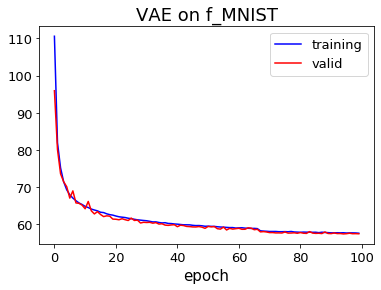

In [16]:
training_plot(hist,'VAE on f_MNIST')

In [17]:
def plot_five_reconstruction(input_set,random_idx,encoder,decoder):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_digit = original.reshape(img_rows,img_cols)
                col.imshow(original_digit,cmap='bone')
                col.set_title('original, idx={}'.format(idx))
            if flag == 'out_img':
                encoded_z = encoder.predict(np.expand_dims(original,0),batch_size=1)[2]
                predict = decoder.predict(encoded_z)
                decoded_digit = predict.reshape(img_rows,img_cols)
                col.imshow(decoded_digit,cmap='bone')
                col.set_title('reconstructed, idx={}'.format(idx))
            col.axis('off')

## Traing set reconstruction

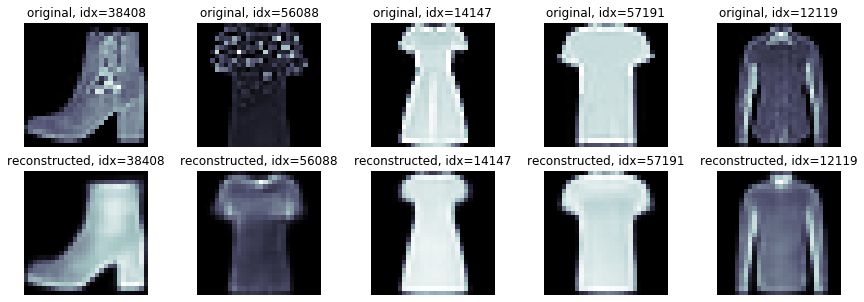

In [18]:
np.random.seed(100)
random_idx = np.random.randint(len(X_train),size=5)
plot_five_reconstruction(X_train,random_idx,encoder,decoder)

## Test set reconstruction

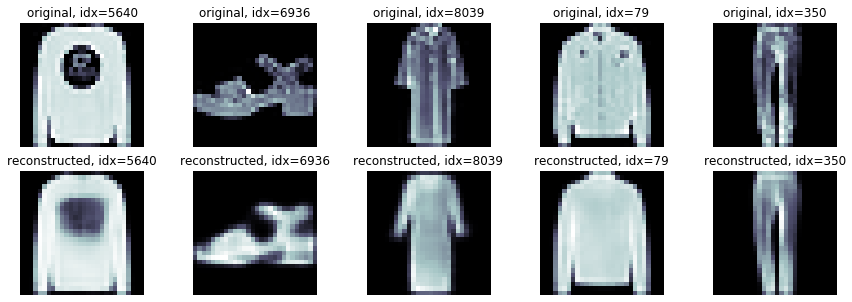

In [19]:
np.random.seed(100)
random_idx = np.random.randint(len(X_test),size=5)
plot_five_reconstruction(X_test,random_idx,encoder,decoder)

## Interpolation on the test set

In [21]:
# X_test_encoded = encoder.predict(X_test, batch_size=1)[2]
# latent_space_df = pd.DataFrame(X_test_encoded,columns=['vector1','vector2'])
# latent_space_df['label'] = y_test
# latent_space_df.head()

In [22]:
# sns.set_context('paper', font_scale=1.5)
# sns.set_style('white')
# plt.figure()
# sns.lmplot('vector1','vector2',data=latent_space_df,hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 40},
#             height=8,palette=sns.color_palette("hls",latent_space_df['label'].nunique()))
# plt.title('Latent space by class')
# plt.show()

In [23]:
# n = 30
# digit_size = 28
# figure = np.zeros((digit_size * n, digit_size * n))

# grid_x = np.linspace(-4, 4, n)
# grid_y = np.linspace(-4, 4, n)

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = decoder.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit
# plt.figure(figsize=(10, 10))
# plt.imshow(figure,cmap='bone')
# plt.axis('off')
# plt.show()

In [24]:
def interpolation(img1,img2,step,encoder,decoder,plot=True):
    img1_encoded_z = encoder.predict(np.expand_dims(img1,0),batch_size=1)[2]
#     print('1: {}'.format(img1_encoded_z))   
    img2_encoded_z = encoder.predict(np.expand_dims(img2,0),batch_size=1)[2]
#     print('2: {}'.format(img2_encoded_z))
    step_size = (img2_encoded_z-img1_encoded_z)/step
#     print('step: {}'.format(step_size))

    step_list = [img1_encoded_z]
    for _ in range(step):
        img1_encoded_z = img1_encoded_z + step_size
        step_list.append(img1_encoded_z)
    if plot:
        os.makedirs('interpolation_images',exist_ok=True)
        fig,axes = plt.subplots(int(np.ceil((step+1)/5)),5, figsize=(5*4, int(np.ceil((step+1)/5))*4))
        for i,(ax,vector) in enumerate(zip(axes.flatten(),step_list)):
            predict = decoder.predict(vector).reshape(img_rows,img_cols)
            ax.imshow(predict,cmap='bone')
            ax.axis('off')
            
            fig_indi,ax_indi = plt.subplots(figsize=(5,5))
            ax_indi.imshow(predict,cmap='bone')
            ax_indi.axis('off')
            plt.title('step {}/{}'.format(i,step),fontsize=24,fontweight='bold')
            fig_indi.savefig('interpolation_images/step_{}.png'.format(i))
            plt.close()
            if i == 0:
                ax.set_title('From Image 1\n0%',fontsize=24,fontweight='bold')
            elif i == step:
                ax.set_title('To Image 2\n100%',fontsize=24,fontweight='bold')
            else:
                ax.set_title('step {}/{}\n{:.0f}%'.format(i,step,i*100/step),fontsize=24,fontweight='bold')
        plt.subplots_adjust(hspace=0.3,left=0.1, wspace=0.02)
        if (step+1)%5 != 0:
            for i in axes.flatten()[(step+1)-len(axes.flatten()):]:
                i.set_visible(False)
        fig.savefig('interpolation_images/summary.png')
    return step_list

[ 25 496]


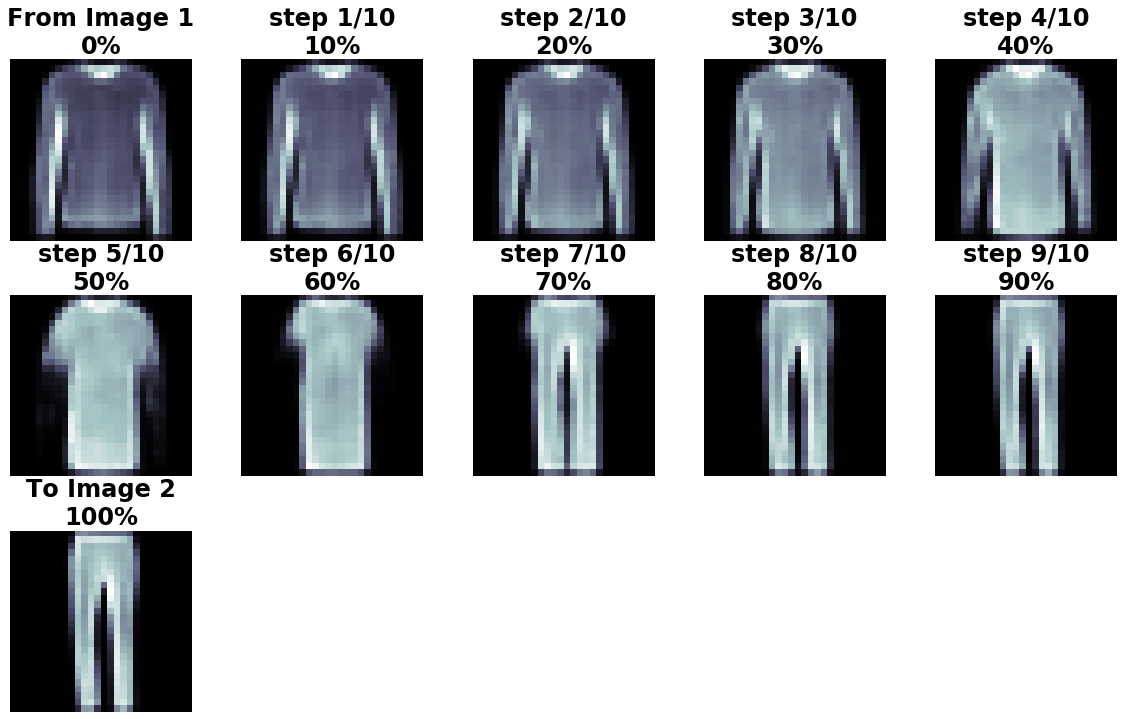

In [25]:
np.random.seed(150)
random_idx_2 = np.random.randint(len(X_test),size=2)
print(random_idx_2)
_ = interpolation(X_test[random_idx_2[0]],X_test[random_idx_2[1]],10,encoder,decoder,plot=True)